# zfit — A simple introduction

In this quick tutorial, we'll show the basic ideas on what you can do with `zfit`, without going into much detail or performing advanced tasks.

First, we will perform the basic imports that we will use along most of the tutorials, and we'll check the `tensorflow` version.



In [1]:
import numpy as np
import tensorflow as tf

import zfit
# Wrapper for some tensorflow functionality
from zfit import ztf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 1.14.0


## Create observables

The observable space in which PDFs are defined is created with the `Space` class

In [2]:
obs = zfit.Space('x', limits=(-10, 10))

## Create data

We create some data using `numpy`. Other constructors, e.g. for `ROOT` files are also available.

In [3]:
mu_true = 0
sigma_true = 1

data_np = np.random.normal(mu_true, sigma_true, size=10000)
data = zfit.data.Data.from_numpy(obs=obs, array=data_np)

## Create a PDF to fit

Let's create a Gaussian PDF so we can fit the dataset. To do this, first we create the fit parameters, which follow a convention similar to `RooFit`:

```
zfit.Parameter(name, initial_value, lower_limit (optional), upper_limit (optional), other options)
```

In [4]:
mu = zfit.Parameter("mu", 2.4, -1., 5.)
sigma = zfit.Parameter("sigma", 1.3, 0, 5.)

Now we instantiate a Gaussian from the zfit PDF library (more on how to create your own PDFs later)

In [5]:
gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma)

This pdf contains several useful methods, such as calculating a probability, calculating its integral, sampling etc.

**Note**: Several objects that are returned from methods, like `integrate`, return `tf.Tensor`, which are graphs that are not executed immediately, but need to be run *explicitely*:

```python
zfit.run(TensorFlow_object)
```

For more information, checkout the [Lazy evaluation and Graphs](https://github.com/zfit/zfit-tutorials/blob/master/Lazy%20Evaluation%20and%20Graphs.ipynb) tutorial.

In [6]:
# Let's get some probabilities. Remember, the probs object is not executed yet
consts = [-1, 0, 1]
probs = gauss.pdf(ztf.constant(consts))
# And now execute the tensorflow graph
result = zfit.run(probs)
print("x values: {}\nresult:   {}".format(consts, result))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
x values: [-1, 0, 1]
result:   [0.01003756 0.05582994 0.17184119]


## Fitting

To fit, we need to take three steps: create the negative $\log\mathcal{L}$, instantiate a minimizer and then minimize the likelihood. 

In [7]:
# Create the negative log likelihood

nll = zfit.loss.UnbinnedNLL(model=gauss, data=data)  # loss

# Load and instantiate a minimizer
minimizer = zfit.minimize.MinuitMinimizer()
minimum = minimizer.minimize(loss=nll)

# Get the fitted values, again by run the variable graphs
params = minimum.params

print("mu={}".format(params[mu]['value']))
print("sigma={}".format(params[sigma]['value']))

Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.
------------------------------------------------------------------
| FCN = 1.433E+04               |      Ncalls=59 (59 total)      |
| EDM = 1.07E-08 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
mu=0.014929700154895365
sigma=1.0141399582973216


And we can plot the result to see how it went.

In [8]:
%matplotlib inline  

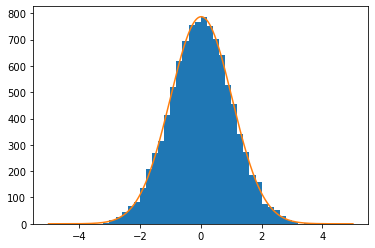

In [9]:
import matplotlib.pyplot as plt
n_bins = 50
range_ = (-5,5)
_ = plt.hist(data_np, bins=n_bins, range=range_)
x = np.linspace(*range_, num=1000)
with gauss.set_norm_range(range_):
    pdf = zfit.run(gauss.pdf(x))
_ = plt.plot(x, data_np.shape[0] / n_bins * (range_[1] - range_[0]) * pdf)

Here, we can see the power of the context managers used to change the normalisation range.

In [10]:
with gauss.set_norm_range((-1e6, 1e6)):  # play around with different norm ranges
# with gauss.set_norm_range((-100, 100)):
    print(zfit.run(gauss.integrate((-0.6, 0.6))))
    print(zfit.run(gauss.integrate((-3, 3))))
    print(zfit.run(gauss.integrate((-100, 100))))

0.4458615879955605
0.9969020831516605
1.0


*(remember the orders of magnitude: sigma of our Gaussian is 1, so 100 is far far away)*

The `FitResult` that we obtained contains information about the minimization and can now be used to calculate the errors

In [11]:
print("Function minimum:", minimum.fmin)
print("Converged:", minimum.converged)
print("Full minimizer information:", minimum.info)

Function minimum: 14329.801568927245
Converged: True
Full minimizer information: {'n_eval': 59, 'original': FMin(fval=14329.801568927245, edm=1.0685411010380407e-08, tolerance=0.1, nfcn=59, ncalls=59, up=0.5, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False)}


In [12]:
errors = minimum.error()

In [13]:
print(errors[mu])

-------------------------------------------------
|       mu        |            Valid            |
-------------------------------------------------
|      Error      |    -0.010    |     0.010    |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
